In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,mean_absolute_error
from pmdarima import auto_arima
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.style.use("fivethirtyeight")

Get Data

In [3]:
dataSet=pd.read_csv('./AAPL (1).csv')
dataSet["Date"] = pd.to_datetime(dataSet["Date"], infer_datetime_format=True)
dataset = dataSet.set_index("Date")

Filter DataFrame

In [4]:
df=dataset["Close"]

Visualire DF

<Axes: title={'center': "AAPL 'Close'"}, xlabel='Date', ylabel='Close Price'>

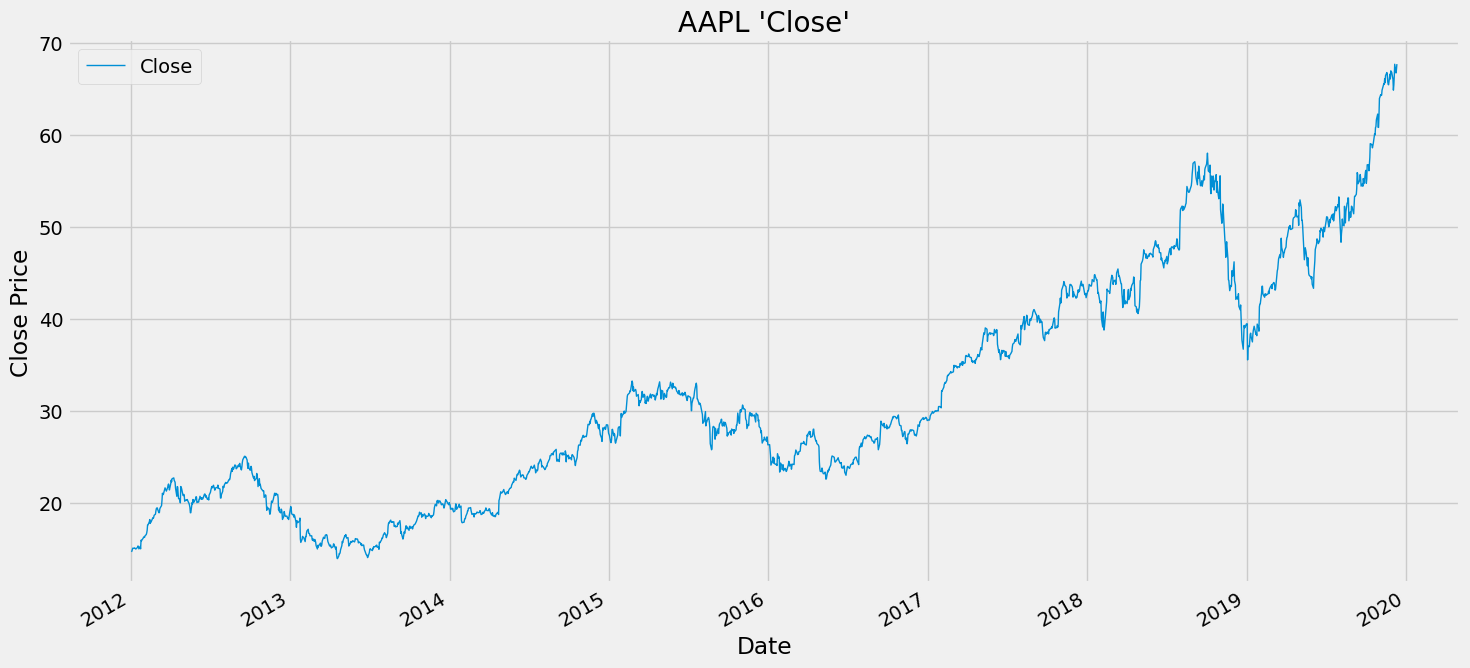

In [5]:
df.plot(figsize=(16,8),xlabel='Date',ylabel='Close Price',title="AAPL 'Close'",legend="Close",linewidth=1)

Get Number Of Train Data

In [6]:
len_data_train = math.floor(len(df)*.9)

Split Data


In [7]:
train=df[:len_data_train]
test=df[len_data_train:]

Plotting Train & Test Data

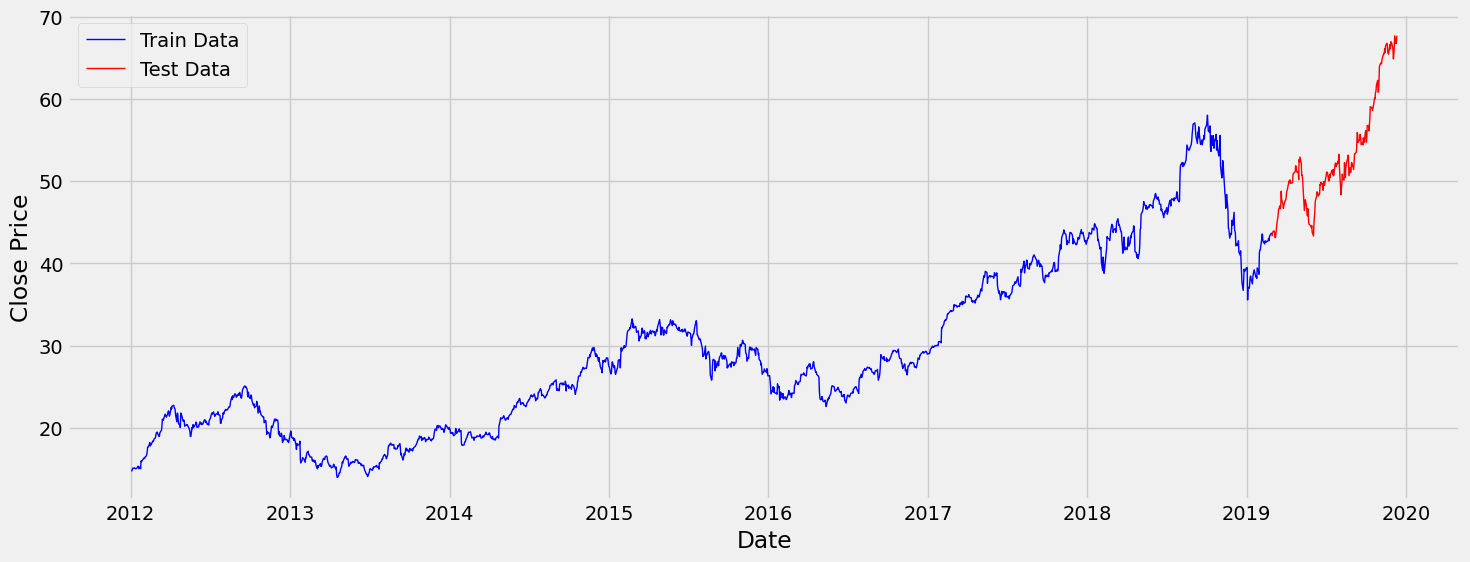

In [8]:
plt.figure(figsize=(16,6))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.plot(train,"blue",label="Train Data",linewidth=1)
plt.plot(test,"red",label="Test Data",linewidth=1)
plt.legend()
plt.show()

In [20]:
data_decompose=seasonal_decompose(df,model="additive",period=2)
concat=pd.concat([data_decompose.trend,data_decompose.seasonal,data_decompose.resid,data_decompose.observed],axis=1)
concat.columns = ["Trend","Seasonal","Resid","Actual_Values"]
concat

,Trend,Seasonal,Resid,Actual_Values
Date,,,,
2012-01-03,NaN,0.000612,NaN,14.686786
2012-01-04,14.786964,-0.000612,-0.020638,14.765714
2012-01-05,14.927678,0.000612,0.001352,14.929643
2012-01-06,15.040714,-0.000612,0.045612,15.085714
2012-01-09,15.081250,0.000612,-0.020076,15.061786
...,...,...,...,...
2019-12-05,66.475623,0.000612,-0.081238,66.394997
2019-12-06,67.119999,-0.000612,0.558111,67.677498
2019-12-09,67.064377,0.000612,-0.334986,66.730003


Arima Model

In [10]:
train_trend = data_decompose.trend[1:len_data_train]
test_trend = data_decompose.trend[len_data_train:-1]
stepwise_fit=auto_arima(train_trend,trace=True,suppress_warnings=True)
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=807.978, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-160.175, Time=1.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=811.007, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-711.008, Time=1.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1059.708, Time=2.91 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-1265.804, Time=2.25 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-1500.836, Time=3.03 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.83 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.32 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-1501.512, Time=1.35 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-1265.104, Time=1.25 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=8.70 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=

In [11]:
prediction=[]
training_trend=list(train_trend)
testing_trend=list(test_trend)
n_test_obser=len(test_trend)
for n in range(n_test_obser):
    model=ARIMA(training_trend,order=(5,1,0))
    model_fit=model.fit()
    output=model_fit.forecast()
    prediction.append(output)
    training_trend.append(testing_trend[n])

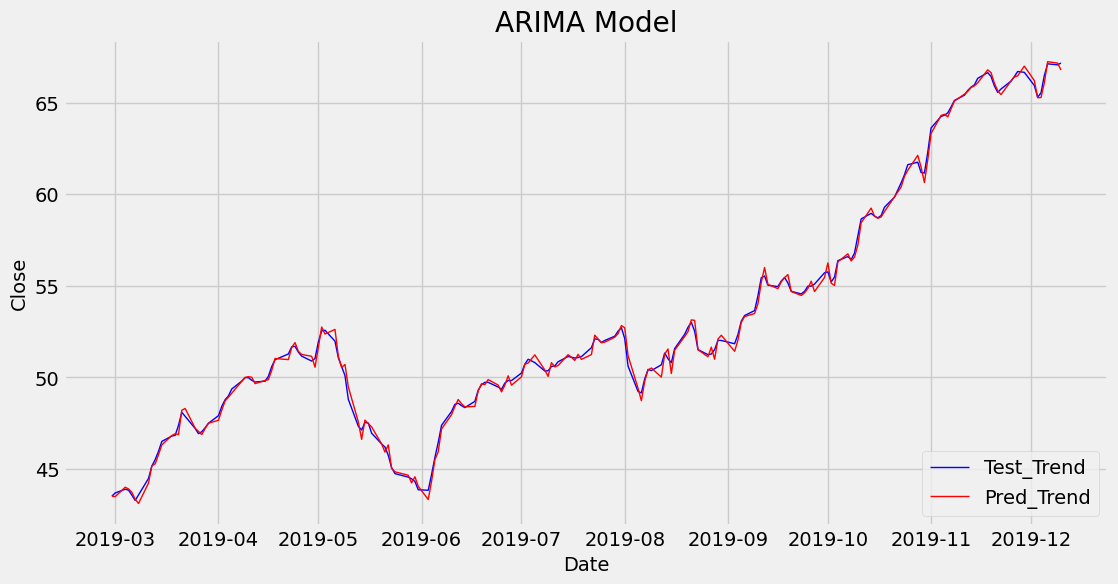

In [58]:
data_range=test_trend.index
plt.figure(figsize=(12, 6))
plt.title("ARIMA Model")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close", fontsize=14)
plt.plot(data_range,test_trend,"blue", linewidth=1)
plt.plot(data_range,prediction,"red",linewidth=1)
plt.legend(["Test_Trend", "Pred_Trend"], loc="lower right")
plt.show()

Lstm Model

In [24]:
rsid_data = data_decompose.resid
rsid_data = rsid_data[1:-1]

In [153]:
# create the training data
train_data = rsid_data[0:len_data_train]
# split the train data
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

# convert the data to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [154]:
 # create the data test
test_data = rsid_data[len_data_train-60:]

# create x_test & y_test
x_test = []
y_test = rsid_data[len_data_train:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])

# convert the data to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [155]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,
              input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
# Compile the Model
model.compile(optimizer="adam", loss="mean_squared_error")
# Train the model
model.fit(x_train, y_train, epochs=25)


Epoch 1/25
55/55 [==============================] - 92s 229ms/step - loss: 0.0276
Epoch 2/25
55/55 [==============================] - 13s 237ms/step - loss: 0.0193
Epoch 3/25
55/55 [==============================] - 10s 179ms/step - loss: 0.0174
Epoch 4/25
55/55 [==============================] - 10s 182ms/step - loss: 0.0175
Epoch 5/25
55/55 [==============================] - 10s 174ms/step - loss: 0.0171
Epoch 6/25
55/55 [==============================] - 11s 199ms/step - loss: 0.0166
Epoch 7/25
55/55 [==============================] - 10s 191ms/step - loss: 0.0166
Epoch 8/25
55/55 [==============================] - 10s 189ms/step - loss: 0.0169
Epoch 9/25
55/55 [==============================] - 10s 174ms/step - loss: 0.0170
Epoch 10/25
55/55 [==============================] - 10s 184ms/step - loss: 0.0167
Epoch 11/25
55/55 [==============================] - 11s 193ms/step - loss: 0.0168
Epoch 12/25
55/55 [==============================] - 15s 273ms/step - loss: 0.0169
Epoch 13/25
5

In [156]:
# Prodection the data values
pred = model.predict(x_test)

7/7 [==============================] - 12s 86ms/step


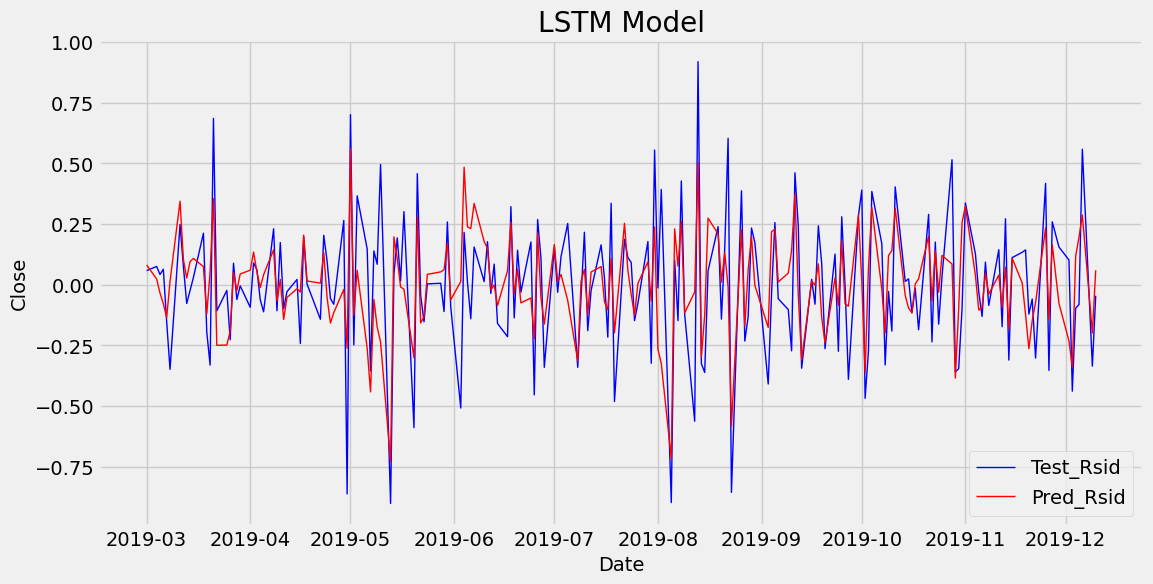

In [157]:
data_range=y_test.index
plt.figure(figsize=(12, 6))
plt.title("LSTM Model")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close", fontsize=14)
plt.plot(data_range,y_test,"blue", linewidth=1)
plt.plot(data_range,pred,"red",linewidth=1)
plt.legend(["Test_Rsid", "Pred_Rsid"], loc="lower right")
plt.show()

Hybride Model


In [158]:
pred_arima = np.array(prediction[:-1])
pred_lstm = pred
seaonal_pred = data_decompose.seasonal.values[1:-1]
seaonal_pred = np.array(seaonal_pred[len_data_train:])
seaonal_pred = seaonal_pred.reshape(198,1)
pred_hyb = pred_arima+pred_lstm + seaonal_pred

actual = df[1:-1]
actual =actual[len_data_train:]

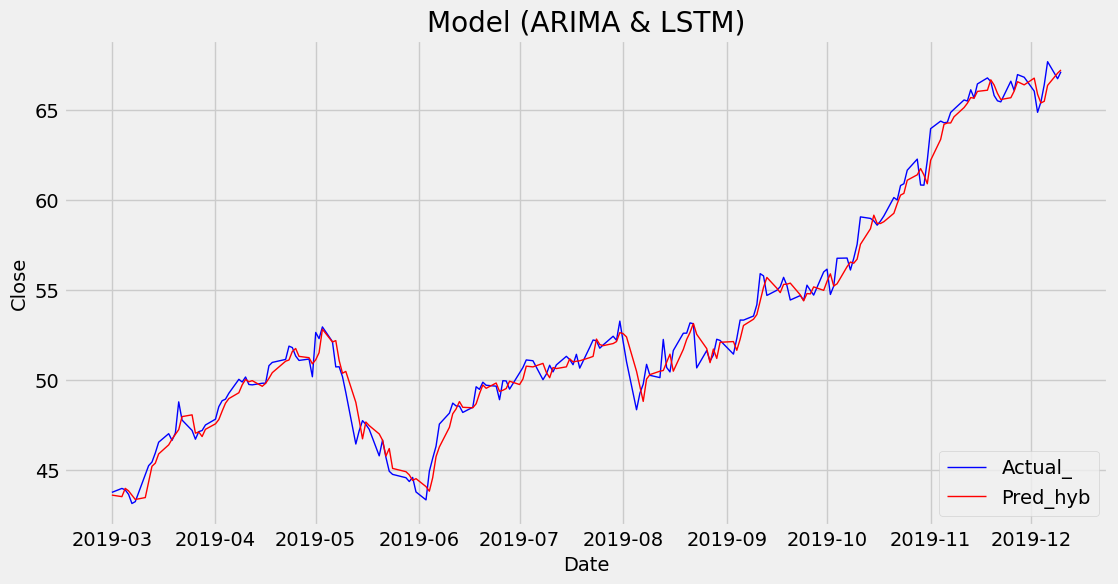

In [159]:
date_range = y_test.index
plt.figure(figsize=(12, 6))
plt.title("Model (ARIMA & LSTM)")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close", fontsize=14)
plt.plot(data_range,actual,"blue", linewidth=1)
plt.plot(data_range,pred_hyb,"red",linewidth=1)
plt.legend(["Actual_", "Pred_hyb"], loc="lower right")
plt.show()

In [162]:
print(f"MAE : {mean_absolute_error(actual,pred_hyb)}")
print(f"MSE : {mean_squared_error(actual,pred_hyb)}")

MAE : 0.5301726722330391
MSE : 0.48130799604875446
